In [2]:
import uproot
import awkward as ak
import numpy as np
import sklearn.metrics as m
import boost_histogram as bh
import glob
import os
from scipy.interpolate import interp1d

from matplotlib import pyplot as plt
import matplotlib as mpl
import matplotlib.gridspec as gridspec

from cycler import cycler
import mplhep as hep
# plt.style.use(hep.style.ROOT)
mpl.rcParams['mathtext.fontset'] = 'stix'
mpl.rcParams['font.family'] = 'STIXGeneral'

def _p4_from_ptetaphie(pt, eta, phi, energy):
    import vector
    vector.register_awkward()
    return vector.zip({'pt': pt, 'eta': eta, 'phi': phi, 'energy': energy})
def _p4_from_ptetaphim(pt, eta, phi, mass):
    import vector
    vector.register_awkward()
    return vector.zip({'pt': pt, 'eta': eta, 'phi': phi, 'mass': mass})

from concurrent.futures import ThreadPoolExecutor
from functools import reduce
from operator import add

In [3]:
# Categories
from types import SimpleNamespace
config = SimpleNamespace(
    categories = { # category name: (sample list, selection, label, color)

        # the official version
        "bkg_wjets": (["wjets"], "d.lep_pt > 0", r"W+jets", "lightcyan"),
        "bkg_t_matched": (["ttbarsl", "wwsl", "twsl"], "~d.is_wcb & d.is_t_matched", r"$t\overline{t}+tW+WW$: top($bqq'$)", "blue"),
        "bkg_tbc_matched": (["ttbarsl", "wwsl", "twsl"], "~d.is_wcb & d.is_tbc_matched", r"$t\overline{t}+tW+WW$: top($bc$)", "orange"),
        "bkg_tbq_matched": (["ttbarsl", "wwsl", "twsl"], "~d.is_wcb & d.is_tbq_matched", r"$t\overline{t}+tW+WW$: top($bq$)", "wheat"),
        "bkg_non_matched": (["ttbarsl", "wwsl", "twsl"], "~d.is_wcb & d.is_non_matched", r"$t\overline{t}+tW+WW$: non", "darkcyan"),
        "bkg_w_matched": (["ttbarsl", "wwsl", "twsl"], "~d.is_wcb & d.is_w_matched", r"$t\overline{t}+tW+WW$: $W(qq')$", "red"),
        # signals
        "sig_tbh_m60":  (["tbh_m60"], "d.lep_pt > 0", r"Signal $H^{\pm}\rightarrow bc$ ($m_{H^{\pm}}=60$ GeV)", "red"),
        "sig_tbh_m70":  (["tbh_m70"], "d.lep_pt > 0", r"Signal $H^{\pm}\rightarrow bc$ ($m_{H^{\pm}}=70$ GeV)", "orange"),
        "sig_tbh_m80":  (["tbh_m80"], "d.lep_pt > 0", r"Signal $H^{\pm}\rightarrow bc$ ($m_{H^{\pm}}=80$ GeV)", "yellow"),
        "sig_tbh_m90":  (["tbh_m90"], "d.lep_pt > 0", r"Signal $H^{\pm}\rightarrow bc$ ($m_{H^{\pm}}=90$ GeV)", "green"),
        "sig_tbh_m100": (["tbh_m100"], "d.lep_pt > 0", r"Signal $H^{\pm}\rightarrow bc$ ($m_{H^{\pm}}=100$ GeV)", "cyan"),
        "sig_tbh_m110": (["tbh_m110"], "d.lep_pt > 0", r"Signal $H^{\pm}\rightarrow bc$ ($m_{H^{\pm}}=110$ GeV)", "blue"),
        "sig_tbh_m120": (["tbh_m120"], "d.lep_pt > 0", r"Signal $H^{\pm}\rightarrow bc$ ($m_{H^{\pm}}=120$ GeV)", "purple"),
        "sig_tbh_m130": (["tbh_m130"], "d.lep_pt > 0", r"Signal $H^{\pm}\rightarrow bc$ ($m_{H^{\pm}}=130$ GeV)", "magenta"),
        "sig_tbh_m140": (["tbh_m140"], "d.lep_pt > 0", r"Signal $H^{\pm}\rightarrow bc$ ($m_{H^{\pm}}=140$ GeV)", "brown"),
        "sig_tbh_m150": (["tbh_m150"], "d.lep_pt > 0", r"Signal $H^{\pm}\rightarrow bc$ ($m_{H^{\pm}}=150$ GeV)", "gray"),
        "sig_tbh_m160": (["tbh_m160"], "d.lep_pt > 0", r"Signal $H^{\pm}\rightarrow bc$ ($m_{H^{\pm}}=160$ GeV)", "black"),

    },

    variables = {
        "n_fj": ("ak.num(d.fj_pt)", bh.axis.Regular(5, 0, 5)),
        "fjcand_pt": ("d.fjcand_p4.pt", bh.axis.Regular(50, 0, 500)),
        "fjcand_eta": ("d.fjcand_p4.eta", bh.axis.Regular(50, -5, 5)),
        "fjcand_mass": ("d.fjcand_p4.mass", bh.axis.Regular(50, 0, 250)),
        "fjcand_sdmass": ("d.fjcand_sdmass", bh.axis.Regular(50, 0, 250)),
        "fjcand_sdmass_bw10": ("d.fjcand_sdmass", bh.axis.Regular(25, 0, 250)),
        "fjcandm_sdmass_bw10": ("d.fjcandm_sdmass", bh.axis.Regular(25, 0, 250)),
        "fjcand_sophon_discr": ("d.fj_sophon_discr[:,0]", bh.axis.Regular(100, 0., 1)),
        "fjcand_sophon_discr2": ("d.fj_sophon_discr2[:,0]", bh.axis.Regular(100, 0., 1)),
        "fjcand_sophon_discr_custom": ("d.fj_sophon_probXbc[:,0] / (d.fj_sophon_probXbc[:,0] + d.fj_sophon_probXbq[:,0] + d.fj_sophon_probXcs[:,0] + d.fj_sophon_probXqq[:,0] + d.fj_sophon_probXbqq[:,0])", bh.axis.Regular(100, 0.5, 1)),
        "lep_pt": ("d.lep_pt", bh.axis.Regular(50, 0, 500)),
        "lep_eta": ("d.lep_eta", bh.axis.Regular(50, -5, 5)),
        "met_pt": ("d.met_pt", bh.axis.Regular(50, 0, 500)),
        "wlep_pt": ("(d.met_p4 + d.lep_p4).pt", bh.axis.Regular(50, 0, 500)),
        "n_extbtagMPjet": ("ak.num(d.extbtagMPjet_p4)", bh.axis.Regular(6, 0, 6)),
        # "n_extbtagMPjet": ("ak.num(d.jet_p4[(d.jet_sophonAK4_probB > 0.297) & (d.jet_p4.deltaR(d.fjcand_p4) > 0.8)])", bh.axis.Regular(6, 0, 6)),
        "n_extjet": ("ak.num(d.jet_p4[(d.jet_p4.deltaR(d.fjcand_p4) > 0.8)])", bh.axis.Regular(10, 0, 10)),
        "n_cleanjet": ("ak.num(d.jet_p4[(d.jet_p4.deltaR(d.fjcand_p4) > 0.8) & (d.jet_p4.deltaR(d.lep_p4) > 0.4)])", bh.axis.Regular(10, 0, 10)),
        "evt_dnn_score": ("d.score_is_w_matched", bh.axis.Regular(20, 0, 1)),
        "evt_dnn_score_high": ("d.score_is_w_matched", bh.axis.Regular(25, 0.8, 1)),
        "evt_dnn_score_tonly": ("d.score_is_w_matched / (1 - d.score_is_wjets)", bh.axis.Regular(50, 0, 1)),
        "dr_extbtagMPjet_12_fjcand_min": ("d.dr_extbtagMPjet_12_fjcand_min", bh.axis.Regular(30, 0, 6)),

        # for template making
        "sophon_discr2_dnn_hist2d": (("d.fj_sophon_discr2[:,0]", "d.score_is_w_matched"), (bh.axis.Regular(100, 0.9, 1), bh.axis.Regular(100, 0, 1))),
        "sophon_discr3_dnn_hist2d": (("d.fj_sophon_discr3[:,0]", "d.score_is_w_matched"), (bh.axis.Regular(100, 0.9, 1), bh.axis.Regular(100, 0, 1))),
    },

    signal_mul_factor = 1,

    categories_merged = {
        "bkg_wjets": ["bkg_wjets"],
        "bkg_allwhad_tbc": ["bkg_tbc_matched"],
        "bkg_allwhad_others": ["bkg_t_matched", "bkg_w_matched", "bkg_tbq_matched", "bkg_non_matched"],
        # "sig": ["sig_t_matched", "sig_w_matched", "sig_tbc_matched", "sig_tbq_matched", "sig_non_matched"],
        "sig_m60": [ "sig_tbh_m60"],
        "sig_m70": [ "sig_tbh_m70"],
        "sig_m80": [ "sig_tbh_m80"],
        "sig_m90": [ "sig_tbh_m90"],
        "sig_m100":[ "sig_tbh_m100"],
        "sig_m110":[ "sig_tbh_m110"],
        "sig_m120":[ "sig_tbh_m120"],
        "sig_m130":[ "sig_tbh_m130"],
        "sig_m140":[ "sig_tbh_m140"],
        "sig_m150":[ "sig_tbh_m150"],
        "sig_m160":[ "sig_tbh_m160"],
    },
    sig_list = {
        "sig_m60": [ "sig_tbh_m60"],
        "sig_m70": [ "sig_tbh_m70"],
        "sig_m80": [ "sig_tbh_m80"],
        "sig_m90": [ "sig_tbh_m90"],
        "sig_m100":[ "sig_tbh_m100"],
        "sig_m110":[ "sig_tbh_m110"],
        "sig_m120":[ "sig_tbh_m120"],
        "sig_m130":[ "sig_tbh_m130"],
        "sig_m140":[ "sig_tbh_m140"],
        "sig_m150":[ "sig_tbh_m150"],
        "sig_m160":[ "sig_tbh_m160"],
    },
    bkg_list = {
        "bkg_wjets": ["bkg_wjets"],
        "bkg_allwhad_tbc": ["bkg_tbc_matched"],
        "bkg_allwhad_others": ["bkg_t_matched", "bkg_w_matched", "bkg_tbq_matched", "bkg_non_matched"],
    },
)
# btag_wp = {"L": 0.0557, "M": 0.297, "T": 0.725}


### New templates

In [3]:
import pickle

with open("/home/pku/zhaoyz/pheno/notebooks_hbc/pickles/wcb_tbhana_templ_3dhist_v0318.pickle", "rb") as f:
    templs_summary_3d = pickle.load(f)

In [10]:

aux_weight_scale = 140. / 450 # for Full-Run2
print('Apply aux weight scale:', aux_weight_scale)

import copy

_templs = copy.deepcopy(templs_summary_3d)

sophon_discr_thres  = {
    "pt200to250" : 0.9,
    "pt250to300" : 0.7,
    "pt300to400" : 0.92,
    "pt400toInf" : 0.75
}

evt_dnn_thres  = {
    "pt200to250" : 0.3,
    "pt250to300" : 0.3,
    "pt300to400" : 0.3,
    "pt400toInf" : 0.3
}

pt_to_run = "pt400toInf" # set the pt bin here
filedir = f'./datacards_{pt_to_run}'

for sig_idx, sig_sam in enumerate(list(config.sig_list.keys())):
    sig_sam_dir = f"{filedir}/{sig_sam}"
    _ = os.system(f"mkdir -p {sig_sam_dir}")
    clist = list(config.bkg_list.keys()) + [sig_sam] # categories to run for one mass point
    
    data_obs_pass = {}
    data_obs_fail = {}
    
    for pt_bin in [pt_to_run]:
        hist_out_pass = {}
        hist_out_fail = {}
        for cm in clist:
            hist_out_pass[f"{cm}"] = copy.deepcopy(_templs[f"{pt_bin}_nom"][cm][(int(sophon_discr_thres[pt_bin]*100)-50)::bh.sum, int((int(evt_dnn_thres[pt_bin]*100))/5)::bh.sum, :]) # nominal value/hist
            hist_out_fail[f"{cm}"] = copy.deepcopy(_templs[f"{pt_bin}_nom"][cm][(int(sophon_discr_thres[pt_bin]*100)-50)::bh.sum, 0:int((int(evt_dnn_thres[pt_bin]*100))/5):bh.sum, :])       # nominal value/hist
            
        for target_flv in ["bjet", "cjet", "ljet"]:
            for target_region in ["B1", "B2", "C1", "C2", "N"]:
                for target_variation in ["up", "down"]:
                    _variation = "Up" if target_variation == "up" else "Down"
                    
                    # for all bkg
                    nevt_tot_nom = sum(_templs[f"{pt_bin}_nom"][cm].view(flow=True).value.sum() for cm in config.bkg_list)
                    nevt_tot_flv = sum(_templs[f"{pt_bin}_{target_flv}_{target_region}_{target_variation}"][cm].view(flow=True).value.sum() for cm in config.bkg_list)
                    fac =  nevt_tot_nom / nevt_tot_flv

                    for cm in config.bkg_list:
                        n = f"{cm}_ftag_{target_flv}_{target_region}{_variation}"

                        hist_out_pass[n] = copy.deepcopy(_templs[f"{pt_bin}_{target_flv}_{target_region}_{target_variation}"][cm][(int(sophon_discr_thres[pt_bin]*100)-50)::bh.sum, int((int(evt_dnn_thres[pt_bin]*100))/5)::bh.sum, :])
                        hist_out_pass[n].view().value *= fac
                        hist_out_pass[n].view().value = np.maximum(hist_out_pass[n].view().value, 1e-3)
                        hist_out_pass[n].view().variance *= 0
                        
                        hist_out_fail[n] = copy.deepcopy(_templs[f"{pt_bin}_{target_flv}_{target_region}_{target_variation}"][cm][(int(sophon_discr_thres[pt_bin]*100)-50)::bh.sum, 0:int((int(evt_dnn_thres[pt_bin]*100))/5):bh.sum, :])
                        hist_out_fail[n].view().value *= fac
                        hist_out_fail[n].view().value = np.maximum(hist_out_fail[n].view().value, 1e-3)
                        hist_out_fail[n].view().variance *= 0

                    # for sig
                    nevt_tot_nom = sum(_templs[f"{pt_bin}_nom"][cm].view(flow=True).value.sum() for cm in [sig_sam])
                    nevt_tot_flv = sum(_templs[f"{pt_bin}_{target_flv}_{target_region}_{target_variation}"][cm].view(flow=True).value.sum() for cm in [sig_sam])
                    fac =  nevt_tot_nom / nevt_tot_flv
                    
                    for cm in [sig_sam]:
                        n = f"{cm}_ftag_{target_flv}_{target_region}{_variation}"
                        
                        hist_out_pass[n] = copy.deepcopy(_templs[f"{pt_bin}_{target_flv}_{target_region}_{target_variation}"][cm][(int(sophon_discr_thres[pt_bin]*100)-50)::bh.sum, int((int(evt_dnn_thres[pt_bin]*100))/5)::bh.sum, :])
                        hist_out_pass[n].view().value *= fac
                        hist_out_pass[n].view().value = np.maximum(hist_out_pass[n].view().value, 1e-3)
                        hist_out_pass[n].view().variance *= 0
                        
                        hist_out_fail[n] = copy.deepcopy(_templs[f"{pt_bin}_{target_flv}_{target_region}_{target_variation}"][cm][(int(sophon_discr_thres[pt_bin]*100)-50)::bh.sum, 0:int((int(evt_dnn_thres[pt_bin]*100))/5):bh.sum, :])
                        hist_out_fail[n].view().value *= fac
                        hist_out_fail[n].view().value = np.maximum(hist_out_fail[n].view().value, 1e-3)
                        hist_out_fail[n].view().variance *= 0

        hist_out_pass[f'data_obs'] = sum(hist_out_pass[f"{cm}"] for cm in config.bkg_list)
        hist_out_fail[f'data_obs'] = sum(hist_out_fail[f"{cm}"] for cm in config.bkg_list)
        
        # aux weight scale
        # print(1,hist_out_pass)
        for n in hist_out_pass:
            hist_out_pass[n].view().value *= aux_weight_scale
            # hist_out[n].view().variance *= aux_weight_scale**2
            hist_out_pass[n].view().variance *= 0
        # print(2,hist_out_pass)
        for n in hist_out_fail:
            hist_out_fail[n].view().value *= aux_weight_scale
            # hist_out[n].view().variance *= aux_weight_scale**2
            hist_out_fail[n].view().variance *= 0
            
        data_obs_pass[pt_bin] = hist_out_pass[f'data_obs'].values().sum()
        data_obs_fail[pt_bin] = hist_out_fail[f'data_obs'].values().sum()
        
        print(f"{sig_sam} & {pt_bin} pass observation:", hist_out_pass[f'data_obs'].values().sum())
        print(f"{sig_sam} & {pt_bin} fail observation:", hist_out_fail[f'data_obs'].values().sum())

        with uproot.recreate(f'{sig_sam_dir}/input_pass.root') as fw:
            for n in hist_out_pass:
                if "sig" not in n:
                    fw[n] = hist_out_pass[n]
                else:
                    # need to rename, e.g., "sig_m60" to "sig"
                    sig_name = n.replace(sig_sam, "sig")
                    fw[sig_name] = hist_out_pass[n]

        with uproot.recreate(f'{sig_sam_dir}/input_fail.root') as fw:
            for n in hist_out_fail:
                if "sig" not in n:
                    fw[n] = hist_out_fail[n]
                else:
                    # need to rename, e.g., "sig_m60" to "sig"
                    sig_name = n.replace(sig_sam, "sig")
                    fw[sig_name] = hist_out_fail[n]
                    
        # print("check:", data_obs_dict[pt_bin], hist_out[n].values().sum())
                        
    print("pass",data_obs_pass)
    print("fail",data_obs_fail)
    lines = open(f'{filedir}/datacard_tmpl.txt').readlines()
    for i, line in enumerate(lines):
        if line.startswith('observation'):
            lines[i] = f'observation {data_obs_pass[pt_to_run]} {data_obs_fail[pt_to_run]}\n'
    
    with open(f'{sig_sam_dir}/datacard.txt', 'w') as f:
        f.writelines(lines)
    print("\n")

Apply aux weight scale: 0.3111111111111111
sig_m60 & pt400toInf pass observation: 62.45439089547585
sig_m60 & pt400toInf fail observation: 9055.809769449543
pass {'pt400toInf': 62.45439089547585}
fail {'pt400toInf': 9055.809769449543}


sig_m70 & pt400toInf pass observation: 62.45439089547585
sig_m70 & pt400toInf fail observation: 9055.809769449543
pass {'pt400toInf': 62.45439089547585}
fail {'pt400toInf': 9055.809769449543}


sig_m80 & pt400toInf pass observation: 62.45439089547585
sig_m80 & pt400toInf fail observation: 9055.809769449543
pass {'pt400toInf': 62.45439089547585}
fail {'pt400toInf': 9055.809769449543}


sig_m90 & pt400toInf pass observation: 62.45439089547585
sig_m90 & pt400toInf fail observation: 9055.809769449543
pass {'pt400toInf': 62.45439089547585}
fail {'pt400toInf': 9055.809769449543}


sig_m100 & pt400toInf pass observation: 62.45439089547585
sig_m100 & pt400toInf fail observation: 9055.809769449543
pass {'pt400toInf': 62.45439089547585}
fail {'pt400toInf': 9055.8

### Plot the limits

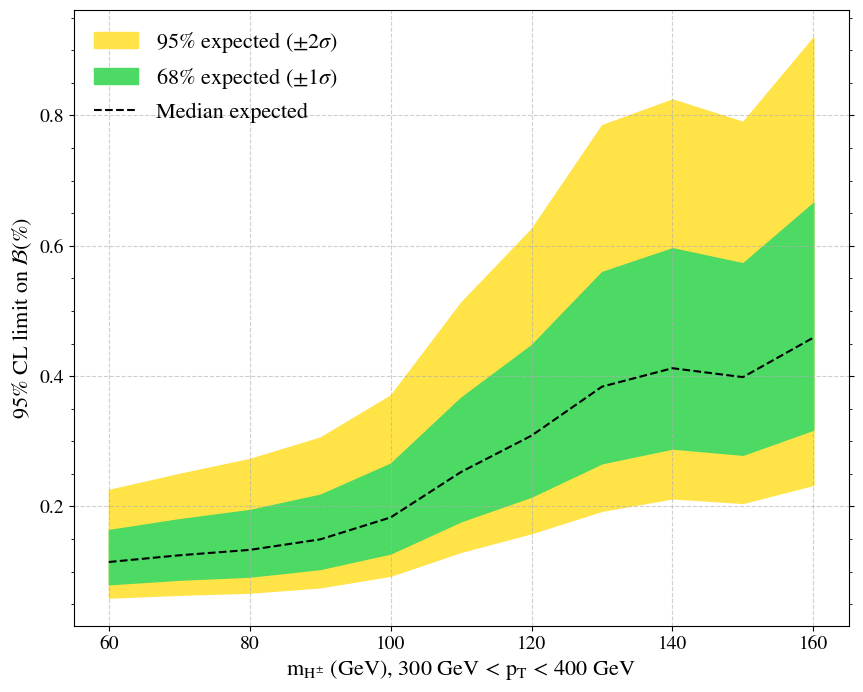

In [12]:
import re
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.ticker import AutoMinorLocator
mpl.rcParams['mathtext.fontset'] = 'stix'
mpl.rcParams['font.family'] = 'STIXGeneral'

# plt.rcParams['text.usetex'] = True
pt_to_run = "pt300to400"
folder_path = f"/home/pku/zhaoyz/pheno/notebooks_hbc/datacards_{pt_to_run}"
mass_points = [mp for mp in range(60, 170, 10)]
observed_limits = []
expected_2_5 = []
expected_16 = []
expected_50 = []
expected_84 = []
expected_97_5 = []

pt_range_str_dict = {
    "pt200to250" : r", 200 GeV < $\mathrm{p}_\mathrm{T}$ < 250 GeV",
    "pt250to300" : r", 250 GeV < $\mathrm{p}_\mathrm{T}$ < 300 GeV",
    "pt300to400" : r", 300 GeV < $\mathrm{p}_\mathrm{T}$ < 400 GeV",
    "pt400toInf" : r", $\mathrm{p}_\mathrm{T}$ > 400 GeV",
}

pt_range_str = pt_range_str_dict[pt_to_run]

for sig_idx, sig_sam in enumerate(list(config.sig_list.keys())):
    folder_path_i = f"{folder_path}/{sig_sam}"
    filename = "ObservedAsymptoticLimits.txt"
    file_path = os.path.join(folder_path_i, filename)
    with open(file_path, "r") as file:
        content = file.read()
        pattern = r"r < (\d+\.\d+)"
        limits = re.findall(pattern, content)
        limits = [float(limit) for limit in limits]
        observed_limits.append(limits[0])
        expected_2_5.append(limits[1])
        expected_16.append(limits[2])
        expected_50.append(limits[3])
        expected_84.append(limits[4])
        expected_97_5.append(limits[5])

plt.figure(figsize=(10, 8))

ax = plt.gca()
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.tick_params(axis='y', which='both', right=True)  # 启用右轴的刻度和次要刻度

# 填充 Brazil Band 区域
plt.fill_between(mass_points, expected_2_5, expected_97_5, color='#ffe347', label=r'95% expected ($\pm2 \sigma$)') # r'Expected $\pm2 \sigma$'
plt.fill_between(mass_points, expected_16, expected_84, color='#4cd964', label=r'68% expected ($\pm1 \sigma$)') # r'Expected $\pm1 \sigma$'

# 绘制 Expected 50% 线
plt.plot(mass_points, expected_50, color='black', linestyle='--', label='Median expected')

# 绘制 Observed Limit 线
# plt.plot(mass_points, observed_limits, color='red', marker='o', label='Observed Limit')

# 添加标签和标题
plt.xlabel(r'$\mathcal{m}_{\mathrm{H}^{\pm}}$ (GeV)' + pt_range_str, fontsize=16)
plt.ylabel('95% CL limit on ' + r'$\mathcal{B}$' + "(%)", fontsize=16)
# plt.title('Brazil Band Plot', fontsize=16)
plt.legend(loc='upper left', fontsize=16, frameon = False)
plt.grid(True, linestyle='--', alpha=0.6)

plt.tick_params(axis='x', labelsize=14)  # x轴刻度字体大小
plt.tick_params(axis='y', labelsize=14)  # y轴刻度字体大小
# 显示图像

plt.savefig(f"./exclude_{pt_to_run}_v3.pdf", bbox_inches='tight')
plt.show()

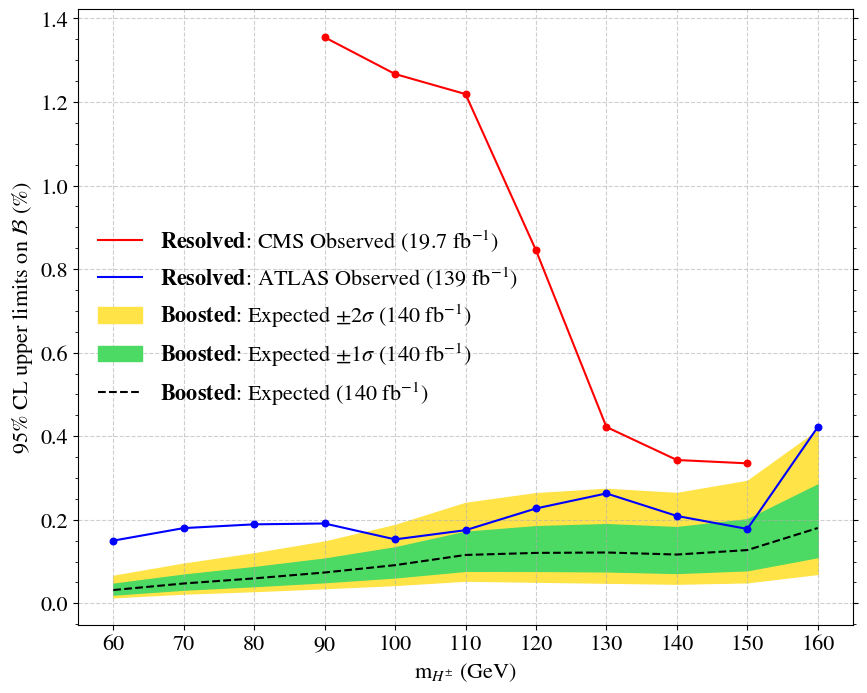

In [9]:
import uproot
import awkward as ak
import numpy as np
import sklearn.metrics as m
import boost_histogram as bh
import glob
import os
from scipy.interpolate import interp1d

from matplotlib import pyplot as plt
import matplotlib as mpl
import matplotlib.gridspec as gridspec

from cycler import cycler
import mplhep as hep
# plt.style.use(hep.style.ROOT)
mpl.rcParams['mathtext.fontset'] = 'stix'
mpl.rcParams['font.family'] = 'STIXGeneral'

def _p4_from_ptetaphie(pt, eta, phi, energy):
    import vector
    vector.register_awkward()
    return vector.zip({'pt': pt, 'eta': eta, 'phi': phi, 'energy': energy})
def _p4_from_ptetaphim(pt, eta, phi, mass):
    import vector
    vector.register_awkward()
    return vector.zip({'pt': pt, 'eta': eta, 'phi': phi, 'mass': mass})

from concurrent.futures import ThreadPoolExecutor
from functools import reduce
from operator import add

import re
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.ticker import AutoMinorLocator
mpl.rcParams['mathtext.fontset'] = 'stix'
mpl.rcParams['font.family'] = 'STIXGeneral'

# plt.rcParams['text.usetex'] = True

folder_path = "/home/pku/zhaoyz/pheno/notebooks_hbc/datacards"
mass_points = [mp for mp in range(60, 170, 10)]
observed_limits = []
expected_2_5 = []
expected_16 = []
expected_50 = []
expected_84 = []
expected_97_5 = []

for sig_idx, sig_sam in enumerate(list(config.sig_list.keys())):
    folder_path_i = f"{folder_path}/{sig_sam}"
    filename = "ObservedAsymptoticLimits.txt"
    file_path = os.path.join(folder_path_i, filename)
    with open(file_path, "r") as file:
        content = file.read()
        pattern = r"r < (\d+\.\d+)"
        limits = re.findall(pattern, content)
        limits = [float(limit) for limit in limits]
        observed_limits.append(limits[0])
        expected_2_5.append(limits[1])
        expected_16.append(limits[2])
        expected_50.append(limits[3])
        expected_84.append(limits[4])
        expected_97_5.append(limits[5])

plt.figure(figsize=(10, 8))

# plt.rcParams["text.usetex"] = True  # 全局启用（可选）

# observed CMS
cms_observed_mass = [90, 100, 110, 120, 130, 140, 150]
cms_observed_value = [1.355, 1.267, 1.219, 0.845, 0.422, 0.343, 0.335]
plt.scatter(cms_observed_mass, cms_observed_value, color='red',  zorder=10, s = 22)
plt.plot(cms_observed_mass, cms_observed_value, color='red', linestyle='-', label=r'$\mathbf{Resolved}$: CMS Observed (19.7 $\mathrm{fb^{-1}}$)', zorder=8)

# observed ATLAS
cms_observed_mass  = [60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160]
cms_observed_value = [0.150, 0.180, 0.189, 0.191, 0.153, 0.175, 0.227, 0.263, 0.209, 0.178, 0.422]
plt.scatter(cms_observed_mass, cms_observed_value, color='blue',  zorder=10, s = 22)
plt.plot(cms_observed_mass, cms_observed_value, color='blue', linestyle='-', label=r'$\mathbf{Resolved}$: ATLAS Observed (139 $\mathrm{fb^{-1}}$)', zorder=8)

# plot settings
ax = plt.gca()
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.tick_params(axis='y', which='both', right=True)  # 启用右轴的刻度和次要刻度

ax.set_xticks([60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160])  # 显式指定刻度位置

# 填充 Brazil Band 区域
plt.fill_between(mass_points, expected_2_5, expected_97_5, color='#ffe347', label=r'$\mathbf{Boosted}$: Expected $\pm2 \sigma$ (140 $\mathrm{fb^{-1}}$)') # r'Expected $\pm2 \sigma$'
plt.fill_between(mass_points, expected_16, expected_84, color='#4cd964', label=r'$\mathbf{Boosted}$: Expected $\pm1 \sigma$ (140 $\mathrm{fb^{-1}}$)') # r'Expected $\pm1 \sigma$'

# 绘制 Expected 50% 线
plt.plot(mass_points, expected_50, color='black', linestyle='--', label=r'$\mathbf{Boosted}$: Expected (140 $\mathrm{fb^{-1}}$)')

# 绘制 Observed Limit 线
# plt.plot(mass_points, observed_limits, color='red', marker='o', label='Observed Limit')

# 添加标签和标题
plt.xlabel(r'$\mathcal{m}_{H^{\pm}}$ (GeV)', fontsize=16)
plt.ylabel('95% CL upper limits on ' + r'$\mathcal{B}$' + " (%)", fontsize=16)
# plt.title('Brazil Band Plot', fontsize=16)
plt.legend(loc='best', fontsize=16, frameon = False)
plt.grid(True, linestyle='--', alpha=0.6)

plt.tick_params(axis='x', labelsize=16)  # x轴刻度字体大小
plt.tick_params(axis='y', labelsize=16)  # y轴刻度字体大小
# 显示图像

plt.savefig(f"./exclude_v7.pdf", bbox_inches='tight')
plt.show()